This is to install the library deepXDE that will be used in GP03

In [4]:
!pip install deepxde

To Import important libraries to work with.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import deepxde as dde
import deepxde.backend as tf
import pandas as pd

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.



Instructions for updating:
non-resource variables are not supported in the long term


# Domain of analyisis
this defines the domain to be a rectangle of lenght 20 and height 10 units.

In [6]:
x_max = 10
x_min = -10
y_max = 5
y_min = -5

geom = dde.geometry.Rectangle([x_min, y_min], [x_max, y_max])

This uploads the cvs file that will contain the airfoil profile, needed for setting up the boundary condition

In [7]:
df = pd.read_csv('1550 Airfoil_data.csv')

In [8]:
x_values = df['Points:0']
y_values = df['Points:1']
U = df[('U:0')]
V = df[('U:1')]

We have imported the points needed to plot the airfoil. And to test wheter the points are imported correctly, we have plotted airfoil below.

(-0.75, 0.75)

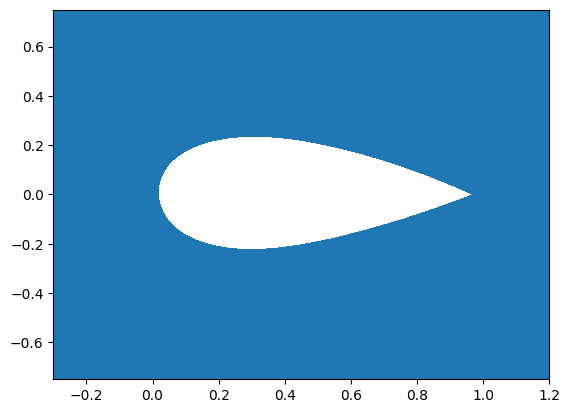

In [9]:
plt.scatter(x_values,y_values)
plt.xlim(-0.3,1.2)
plt.ylim(-0.75,0.75)

Since the domain contains all the points except the points at the boundary of the airfoil that we need, thus from all the points in the domain we will pick the points of the domain where the velocity of the fluid is zero due o no slip. This would represent the geometry of airfoil.

In [10]:
x_geo = []
y_geo = []

for i in range (len(x_values)):
    if U[i] == 0 and V[i] == 0:
        x_geo.append(x_values[i])
        y_geo.append(y_values[i])

Text(0.5, 1.0, 'The Airfoil Cross section')

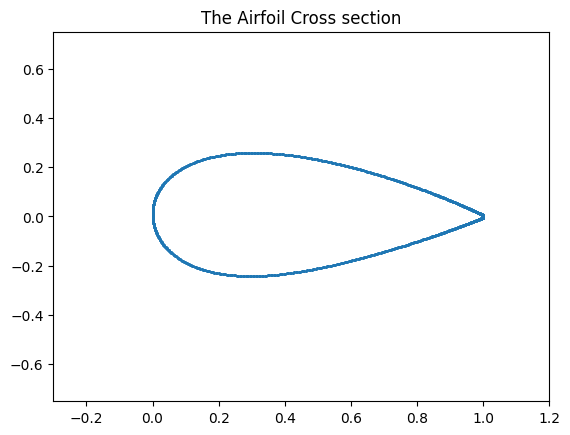

In [11]:
plt.scatter(x_geo,y_geo,s=1)
plt.xlim(-0.3,1.2)
plt.ylim(-0.75,0.75)
plt.title("The Airfoil Cross section")

Now lets define the properties of fluid like Density and Viscosity

In [12]:
d = 1 # Density. For simplicity, taken to be 1
m = 1 # Viscocity. For simplicity taken to be 1

In [13]:
def Governing_equation(X,y):
    # Note that X[0] is x cordinate of domain and X[1] is y cordiante of domain
    # And Y[0] is the u velocity, Y[1] is the v velocity and Y[2] is the pressure
    u = y[:,0:1]
    v = y[:,1:2]
    p = y[:,2:3]

    x = X[:,0:1]
    y = X[:,1:2]
    
    du_dx = dde.grad.jacobian(u,x,i=0,j=0)
    du_dy = dde.grad.jacobian(u,y,i=0,j=0)
    dv_dx = dde.grad.jacobian(v,x,i=0,j=0)
    dv_dy = dde.grad.jacobian(v,y,i=0,j=0)
    dp_dx = dde.grad.jacobian(p,x,i=0,j=0)
    dp_dy = dde.grad.jacobian(p,y,i=0,j=0)

    ddu_ddx = dde.grad.hessian(u,x,i=0,j=0)
    ddu_ddy = dde.grad.hessian(u,y,i=0,j=0)
    ddv_ddx = dde.grad.hessian(v,x,i=0,j=0)
    ddv_ddy = dde.grad.hessian(v,y,i=0,j=0)
  
    Continuity_equation = du_dx + dv_dy
    X_momentum = u*du_dx + v*du_dy + dp_dx - (1/Re)*(ddu_ddx + ddu_ddy)
    Y_momentum = u*dv_dx + v*dv_dy + dp_dy - (1/Re)*(ddv_ddx + ddv_ddy)
    
    return [Continuity_equation , X_momentum , Y_momentum]

In [14]:
# If we define some inlet flow (Reynold's Number)
U_inlet = 1

In [25]:
# If we assume that the gauge pressure at the free stream is zero then the inlet condtion w=can be written as [U,V,P] = [U,0,0]
Inlet_bc = dde.icbc.DirichletBC(
    geom,
    lambda x: [U_inlet,0], # U_inlet for U,0 for V
    lambda x, on_boundary: (x == x_min) & on_boundary
)

# The boundary condition at the other three sides of the rectangle noting the out flow
Outflow_bc = dde.icbc.NeumannBC(
    geom,
    lambda x: [0,0], # Shear stress on fluid ar the boundady is zero
    lambda x,y : (x == x_min) or (y == y_max) or (y == y_min)
)

# The boundary condition at the boundary of airfoil
Airfoil_bc = dde.icbc.DirichletBC(
    geom,
    lambda x: [0,0], # No spil condition
    lambda x,y : (x == x_geo) and (y == y_geo)
)